# STEP 1: downloading fastq file 

In [1]:
!fastq-dump --version


fastq-dump : 3.0.3 ( 3.0.2 )



In [ ]:
# Step 1: Define the SRA accession number and the local output path
sra_accession = 'SRR28543208'  # Replace with your SRA accession number
output_path = './Liver_cancer/'  # Specify your desired local directory path

# Step 2: Create the directory if it doesn't exist
import os
os.makedirs(output_path, exist_ok=True)

# Step 3: Download FASTQ files and save to the local directory
!fastq-dump --split-files --gzip --outdir "{output_path}" {sra_accession}


In [3]:
!zcat Downloads/Liver_cancer/SRR28543207_1.fastq.gz > Downloads/Liver_cancer/SRR28543207_1.fastq

/bin/bash: line 1: Downloads/Liver_cancer/SRR17333959_1.fastq: No such file or directory


# step 2: quality checking with filtering

In [4]:
# Step 2: Run FastQC on filtered FASTQ file for quality control
!conda install -c bioconda fastqc -y  

Retrieving notices: done
Channels:
 - bioconda
 - defaults
Platform: linux-64
Solving environment: done

# All requested packages already installed.



In [1]:
import os

# Paths
input_fastq_file = './Liver_cancer/SRR28543208_1.fastq'  # Input FASTQ file
fastqc_output_dir_preprocessed = 'Liver_cancer/fastqc_reports_SRR28543208/'  # Local directory for reports

# Create output directory if it doesn't exist
os.makedirs(fastqc_output_dir_preprocessed, exist_ok=True)

# Run FastQC
print("Running FastQC for quality checking...")
!fastqc {input_fastq_file} -o {fastqc_output_dir_preprocessed}


Running FastQC for quality checking...
null
Started analysis of SRR28543208_1.fastq
Approx 5% complete for SRR28543208_1.fastq
Approx 10% complete for SRR28543208_1.fastq
Approx 15% complete for SRR28543208_1.fastq
Approx 20% complete for SRR28543208_1.fastq
Approx 25% complete for SRR28543208_1.fastq
Approx 30% complete for SRR28543208_1.fastq
Approx 35% complete for SRR28543208_1.fastq
Approx 40% complete for SRR28543208_1.fastq
Approx 45% complete for SRR28543208_1.fastq
Approx 50% complete for SRR28543208_1.fastq
Approx 55% complete for SRR28543208_1.fastq
Approx 60% complete for SRR28543208_1.fastq
Approx 65% complete for SRR28543208_1.fastq
Approx 70% complete for SRR28543208_1.fastq
Approx 75% complete for SRR28543208_1.fastq
Approx 80% complete for SRR28543208_1.fastq
Approx 85% complete for SRR28543208_1.fastq
Approx 90% complete for SRR28543208_1.fastq
Approx 95% complete for SRR28543208_1.fastq
Analysis complete for SRR28543208_1.fastq


# nanopore Quality reports

In [6]:
!conda install -c bioconda NanoQC -y
!pip install pandas matplotlib seaborn

Channels:
 - bioconda
 - defaults
Platform: linux-64
Solving environment: done

# All requested packages already installed.



In [ ]:
# Step 4: Generate NanoQC Reports
nanoQC_output_dir = './liver/nanoQC_reports'

# Run NanoQC for report generation
os.system(f'nanoQC {filtered_fastq_file} -o {nanoQC_output_dir}')


# Trimming

In [16]:
!pip install cutadapt

In [2]:
!cutadapt -q 20 -o ./Liver_cancer/trimmed_output2.fastq ./Liver_cancer/SRR28543208_1.fastq


This is cutadapt 5.0 with Python 3.12.7
Command line parameters: -q 20 -o ./Liver_cancer/trimmed_output2.fastq ./Liver_cancer/SRR28543208_1.fastq
Processing single-end reads on 1 core ...
[         8=-] 00:00:27       330,000 reads @  55.7 µs/read;   1.08 M reads/minuteError in FASTQ file at line 1343320: Length of sequence and qualities differ


In [27]:
!pip install biopython numpy


In [3]:
from Bio import SeqIO
import numpy as np

# Function to calculate the average quality score of a read
def calculate_average_quality(seq_record):
    qualities = seq_record.letter_annotations["phred_quality"]
    avg_quality = np.mean(qualities)
    return avg_quality

# Function to filter reads based on minimum length and average quality
def filter_trimmed_reads(input_fastq, min_length=1000, min_avg_quality=10):
    filtered_reads = []
    
    for seq_record in SeqIO.parse(input_fastq, "fastq"):
        avg_quality = calculate_average_quality(seq_record)
        seq_length = len(seq_record.seq)
        
        # Apply filters: Minimum length and average quality score
        if seq_length >= min_length and avg_quality >= min_avg_quality:
            filtered_reads.append(seq_record)
    
    return filtered_reads

# Function to save the filtered reads into a new FASTQ file
def save_filtered_reads(filtered_reads, output_fastq):
    with open(output_fastq, "w") as out_handle:
        SeqIO.write(filtered_reads, out_handle, "fastq")
    print(f"Saved {len(filtered_reads)} filtered reads to {output_fastq}")

# Input trimmed FASTQ file
input_fastq = "./Liver_cancer/trimmed_output2.fastq"

# Filter trimmed reads
filtered_reads = filter_trimmed_reads(input_fastq, min_length=1000, min_avg_quality=15)

# Save the filtered reads to a new FASTQ file
output_fastq = "./Liver_cancer/filtered_trimmed_reads2.fastq"
save_filtered_reads(filtered_reads, output_fastq)


/home/vaibhavi-jain/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/vaibhavi-jain/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saved 130674 filtered reads to ./Liver_cancer/filtered_trimmed_reads2.fastq


# downloading human reference fasta chromosome wise

In [4]:
import requests
import os

def download_chromosome_4_ensembl(output_dir):
    # Ensembl URL for chromosome 4 reference genome (GRCh38)
    url = "https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.4.fa.gz"
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Local file path
    local_file = os.path.join(output_dir, os.path.basename(url))
    
    # Download the file
    print(f"Downloading Chromosome 4 from {url}...")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(local_file, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
        print(f"Download complete. File saved at: {local_file}")
    else:
        print(f"Failed to download file. HTTP Status Code: {response.status_code}")

# Specify output directory
output_directory = "./liver/ensembl_chromosome_4"
download_chromosome_4_ensembl(output_directory)

Download complete. File saved at: ./liver/ensembl_chromosome_4/Homo_sapiens.GRCh38.dna.chromosome.4.fa.gz


In [5]:
import os

input_file = "./liver/ensembl_chromosome_4/Homo_sapiens.GRCh38.dna.chromosome.4.fa.gz"
output_file = "./liver/Homo_sapiens.GRCh38.dna.chromosome.4.fa"

# Use os.system to execute the shell command
os.system(f"zcat {input_file} > {output_file}")


0

# Alignment with reference genome

In [1]:
!minimap2 -ax map-ont -p 0 -N 10 /home/vaibhavi-jain/Downloads/liver/Homo_sapiens.GRCh38.dna.chromosome.4.fa /home/vaibhavi-jain/Downloads/Liver_cancer/filtered_trimmed_reads2.fastq > ./Liver_cancer/alignment2.sam


[M::mm_idx_gen::32.475*0.88] collected minimizers
[M::mm_idx_gen::41.203*0.86] sorted minimizers
[M::main::41.203*0.86] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::41.949*0.87] mid_occ = 190
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::42.562*0.86] distinct minimizers: 20781398 (74.69% are singletons); average occurrences: 1.718; average spacing: 5.328; total length: 190214555
[M::worker_pipeline::799.557*1.66] mapped 130674 sequences
[M::main] Version: 2.22-r1101
[M::main] CMD: minimap2 -ax map-ont -p 0 -N 10 /home/vaibhavi-jain/Downloads/liver/Homo_sapiens.GRCh38.dna.chromosome.4.fa /home/vaibhavi-jain/Downloads/Liver_cancer/filtered_trimmed_reads2.fastq
[M::main] Real time: 800.432 sec; CPU: 1331.725 sec; Peak RSS: 2.154 GB


In [17]:
!conda install -c bioconda minimap2 -y

Channels:
 - bioconda
 - defaults
Platform: linux-64
Solving environment: done

# All requested packages already installed.



In [9]:
!pip install pysam

In [2]:
import pysam

# File paths
aligned_sam_file = './Liver_cancer/alignment2.sam'  # Input SAM file
aligned_bam_file = './Liver_cancer/alignment2.bam'  # Output BAM file

# Open the SAM file for reading
samfile = pysam.AlignmentFile(aligned_sam_file, "r")

# Open the BAM file for writing
with pysam.AlignmentFile(aligned_bam_file, "wb", header=samfile.header) as bamfile:
    for read in samfile:
        bamfile.write(read)

print('successfully extracted bam file')

successfully extracted bam file


In [5]:
import pysam

def print_first_bam_records(bam_file, num_records=5):
    """
    Reads and prints the first few alignment records from a BAM file.

    Parameters:
    - bam_file: Path to the BAM file.
    - num_records: Number of records to read and print (default: 5).
    """
    if not os.path.exists(bam_file):
        raise FileNotFoundError(f"BAM file not found: {bam_file}")
    
    print(f"First {num_records} records from {bam_file}:")
    with pysam.AlignmentFile(bam_file, "rb") as bam:
        for i, record in enumerate(bam):
            if i >= num_records:
                break
            print(record)

# Example Usage
bam_file_path = "/home/vaibhavi-jain/Downloads/liver/alignment.bam"  # Replace with your BAM file path
try:
    print_first_bam_records(bam_file_path, num_records=5)
except Exception as e:
    print(f"Error: {e}")



First 5 records from /home/vaibhavi-jain/Downloads/liver/alignment.bam:
SRR28543207.58	0	#0	171670264	60	133S24M2D22M3D13M1I24M1I30M1D59M4I10M8I80M2D6M1I21M3D106M2D70M2D1M1D15M1I92M1D16M3D12M1D40M1I15M1D1M2D6M3D4M1D4M1D7M6D54M1D58M76S	*	0	0	TCTATGTACTTCGTTCAGTTACGTATTGCTGGTGCTGTGAGAGACAAGATTGTTCGTGGACTTAACCTACTTGCCTGTCGCTCTATCTTCTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTGTTAGTAGAATCTTTTATTCAGAAAAAAAAAAACCCTACAAACAAAGCTTTCCCAGCCACACACGGGAGGGGATATGGGTAGGGGGAGGTGTCTGTCCATCAGCCTGGCCCCCAGCCCATGTGGTTTTGGCAGCAATAAGGGGTATGGGGTAATGGCCCAAAAAAGAAATAAAATGGTTTGTGTGTGTATGGGGAGGAAAGGGGTGCAAAGCTGTGGGGAGCGGTGAAGGGGAAGGGACAGACGAGGTCAGTACTAGGAACGCCAGGTGGAGAGGCCATTCCATAACATTTCTTGATCAAACCGCCGTGGACACCTTCTTTGCCCATCAGCAGGACTAGCGTCTTGTCAGTCTTGGTGACAGTGACATTGAAGGTGGGGGCCCCACCGGTGCTCTTGGTACGAAGATCCATGCTAAATTCCCCATCCTGCAGCAGTGAGTCCCGGATCACCGAACATTTCTGGCCCCCGGTATGGCCATTCACACTAAAAACTTGACCGGTCTTTGCCAACCAGGACACCCACCTCAGCTGGCGTGATGTTGACGAACGTTTTCCCGGGGACGGCGGCCCAGACGGAGGCGAGTCCTTGTAGCCGATGGCCGCGTCTGACAGGT

# Post alignment

In [11]:
!pip install pysam

In [8]:
import os

bam_path = "./Liver_cancer/alignment_sorted.bam"
if os.path.exists(bam_path):
    print(f"BAM file exists at {bam_path}.")
else:
    print(f"BAM file does NOT exist at {bam_path}. Please check the file path.")


BAM file exists at ./Liver_cancer/alignment_sorted.bam.


In [4]:
import pysam
import os
# Paths for unsorted and sorted BAM files
unsorted_bam = "./Liver_cancer/alignment2.bam"
sorted_bam = "./Liver_cancer/alignment_sorted2.bam"

# Check if the unsorted BAM file exists
if os.path.exists(unsorted_bam):
    # Sort the BAM file
    pysam.sort("-o", sorted_bam, unsorted_bam)
    print(f"Sorting complete. Sorted BAM file saved at {sorted_bam}.")
else:
    print(f"Unsorted BAM file not found at {unsorted_bam}. Please check the file path.")


Sorting complete. Sorted BAM file saved at ./Liver_cancer/alignment_sorted2.bam.


In [5]:
import pysam

# Path to the sorted BAM file
sorted_bam = "./Liver_cancer/alignment_sorted2.bam"

# Path for the index file
index_output = "./Liver_cancer/alignment_sorted2.bai"

# Index the sorted BAM file
pysam.index(sorted_bam, index_output)
print(f"Indexing complete. Index file saved at {index_output}.")


Indexing complete. Index file saved at ./Liver_cancer/alignment_sorted2.bai.


In [17]:
import pysam

bamfile = pysam.AlignmentFile("./liver/alignment_sorted.bam", "rb")

# Count primary and secondary alignments
primary_count = sum(1 for read in bamfile if not read.is_secondary)
secondary_count = sum(1 for read in bamfile if read.is_secondary)

print(f"Primary alignments: {primary_count}")
print(f"Secondary alignments: {secondary_count}")


Primary alignments: 30490
Secondary alignments: 0


In [14]:
import pysam

try:
    with pysam.AlignmentFile("./Liver_cancer/alignment_sorted.bam", "rb") as bam:
        print("BAM file and index are valid.")
except Exception as e:
    print(f"Error: {e}")


BAM file and index are valid.


# Quantification 

In [1]:
!pip install HTSeq


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 1.8 MB/s eta 0:00:000:00:01m eta 0:00:01


In [6]:
import HTSeq

# Paths to input files
bam_file = "/home/vaibhavi-jain/Downloads/Liver_cancer/alignment_sorted2.bam"
gtf_file = "/home/vaibhavi-jain/Downloads/liver/Homo_sapiens.GRCh38.113.gtf"

# Open GTF file and create gene annotations
gtf = HTSeq.GFF_Reader(gtf_file)
features = HTSeq.GenomicArrayOfSets("auto", stranded=True)
gene_ids = set()

for feature in gtf:
    if feature.type == "exon":
        features[feature.iv] += feature.attr["gene_id"]
        gene_ids.add(feature.attr["gene_id"])

# Initialize dictionary to store counts
counts = {gene_id: 0 for gene_id in gene_ids}

# Process BAM file
bam_reader = HTSeq.BAM_Reader(bam_file)
for aln in bam_reader:
    if not aln.aligned:
        continue
    for iv, val in features[aln.iv].steps():
        for gene_id in val:
            counts[gene_id] += 1

# Save results to a file
with open("./Liver_cancer/gene_counts2.txt", "w") as output_file:
    output_file.write("Gene_ID\tCount\n")
    for gene_id, count in counts.items():
        output_file.write(f"{gene_id}\t{count}\n")

print("Gene counts saved to gene_counts.txt.")


Gene counts saved to gene_counts.txt.


In [7]:
import HTSeq
import numpy as np

# Input files
bam_file = "/home/vaibhavi-jain/Downloads/Liver_cancer/alignment_sorted2.bam"
gtf_file = "/home/vaibhavi-jain/Downloads/liver/Homo_sapiens.GRCh38.113.gtf"

# Parse GTF file for gene annotations
gtf = HTSeq.GFF_Reader(gtf_file)
gene_info = {}
features = HTSeq.GenomicArrayOfSets("auto", stranded=True)

for feature in gtf:
    if feature.type == "exon":
        gene_id = feature.attr.get("gene_id", "")
        if gene_id not in gene_info:
            gene_info[gene_id] = {
                "length": 0,
                "start": feature.iv.start_d if feature.iv.start_d else "",
                "end": feature.iv.end_d if feature.iv.end_d else "",
                "strand": feature.iv.strand if feature.iv.strand else "",
                "annotation": feature.attr.get("gene_name", "")  # Leave blank if gene_name is not available
            }
        gene_info[gene_id]["length"] += feature.iv.length if feature.iv.length else 0
        features[feature.iv] += gene_id

# Initialize counts
counts = {gene_id: 0 for gene_id in gene_info.keys()}

# Process BAM file for read counts
bam_reader = HTSeq.BAM_Reader(bam_file)
for aln in bam_reader:
    if not aln.aligned:
        continue
    for iv, val in features[aln.iv].steps():
        for gene_id in val:
            counts[gene_id] += 1

# Calculate TPM and FPKM
total_counts = sum(counts.values())
lengths = np.array([gene_info[gene_id]["length"] for gene_id in counts])
counts_array = np.array(list(counts.values()))

# FPKM calculation
fpkm = (counts_array / lengths) / (total_counts / 1e6)

# TPM calculation
rpk = counts_array / lengths
scaling_factor = np.sum(rpk) / 1e6
tpm = rpk / scaling_factor

# Write results to a file
output_file = "./Liver_cancer/gene_expression_data2.tsv"
with open(output_file, "w") as f:
    f.write("Gene_ID\tAnnotation\tLength\tStart\tEnd\tStrand\tCount\tFPKM\tTPM\n")
    for gene_id, count in counts.items():
        gene_data = gene_info[gene_id]
        # Ensure blank spaces where data is missing
        annotation = gene_data.get("annotation", "")
        start = gene_data.get("start", "")
        end = gene_data.get("end", "")
        strand = gene_data.get("strand", "")
        length = gene_data.get("length", 0)

        f.write(
            f"{gene_id}\t{annotation}\t{length}\t"
            f"{start}\t{end}\t{strand}\t"
            f"{count}\t{fpkm[list(counts.keys()).index(gene_id)]:.4f}\t"
            f"{tpm[list(counts.keys()).index(gene_id)]:.4f}\n"
        )

print(f"Gene expression data saved to {output_file}.")


Gene expression data saved to ./Liver_cancer/gene_expression_data2.tsv.


In [12]:
import pandas as pd

def extract_common_genes(file1, file2, output_file):
    # Load the files into dataframes
    df1 = pd.read_csv(file1, sep="\t")
    df2 = pd.read_csv(file2, sep="\t")

    # Ensure both dataframes have Gene_ID and TPM columns
    if "Gene_ID" not in df1.columns or "TPM" not in df1.columns:
        raise ValueError(f"File {file1} must contain 'Gene_ID' and 'TPM' columns.")
    if "Gene_ID" not in df2.columns or "TPM" not in df2.columns:
        raise ValueError(f"File {file2} must contain 'Gene_ID' and 'TPM' columns.")

    # Rename TPM columns for clarity
    df1 = df1.rename(columns={"TPM": "TPM_1"})
    df2 = df2.rename(columns={"TPM": "TPM_2"})

    # Merge on Gene_ID to find common genes
    merged_df = pd.merge(df1, df2, on="Gene_ID")

    # Select only Gene_ID and TPM columns from both files
    result = merged_df[["Gene_ID", "TPM_1", "TPM_2"]]

    # Save to output file
    result.to_csv(output_file, sep="\t", index=False)

    print(f"Common genes with TPM values saved to {output_file}")

# Example usage:
# Replace 'file1.tsv' and 'file2.tsv' with your actual file paths
# and specify an output file name.
file1 = "./Liver_cancer/tpm.tsv"
file2 = "./Liver_cancer/tpm2.tsv"
output_file = "./Liver_cancer/common_genes_tpm.tsv"
"
extract_common_genes(file1, file2, output_file)


Common genes with TPM values saved to ./Liver_cancer/common_genes_tpm.tsv


# Differential expression analysis


Data preview:
           Gene_ID  Log2fold change
0  ENSG00000142611             0.72
1  ENSG00000284616             3.26
2  ENSG00000224340             7.56
3  ENSG00000229280            10.07
4  ENSG00000142655             3.28
Number of upregulated genes: 2180
Number of downregulated genes: 1060
Differentially expressed genes saved to: ./Liver_cancer/differentially_expressed_genes.csv


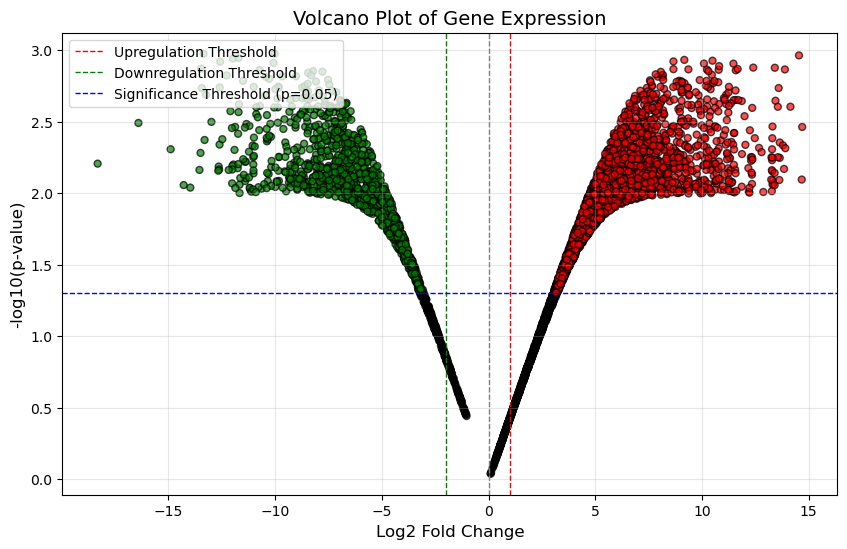

Volcano plot saved as './Liver_cancer/volcano_plot_with_log10pvalue.png'.


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Replace with the path to your actual dataset
file_path = './Liver_cancer/genes_tpm.csv'

# Load the dataset (ensure it's tab-separated or adjust delimiter)
data = pd.read_csv(file_path, sep='\t')

# Check the first few rows of the data
print("Data preview:")
print(data.head())

# Define column names (ensure these match your dataset)
log2fc_column = 'Log2fold change'  # Replace with your column name
gene_id_column = 'Gene_ID'  # Replace with your column name

# Generate synthetic p-values based on log2 fold change
# Add variability for visual effect
np.random.seed(42)  # For reproducibility
data['p_value'] = np.exp(-np.abs(data[log2fc_column])) + np.random.uniform(0.001, 0.01, size=len(data))

# Calculate -log10(p-value) for the y-axis
data['-log10(p-value)'] = -np.log10(data['p_value'] + 1e-10)  # Avoid log(0)

# Define thresholds
threshold_up = 1  # Log2 fold change > 1
threshold_down = -2  # Log2 fold change < -1
significance_level = 0.05  # p-value cutoff

# Assign categories for differentially expressed RNAs
data['category'] = 'Not Significant'  # Default
data.loc[(data[log2fc_column] > threshold_up) & (data['p_value'] < significance_level), 'category'] = 'Upregulated'
data.loc[(data[log2fc_column] < threshold_down) & (data['p_value'] < significance_level), 'category'] = 'Downregulated'

# Extract differentially expressed genes
differentially_expressed = data[data['category'].isin(['Upregulated', 'Downregulated'])]

# Count the number of upregulated and downregulated genes
upregulated_count = (differentially_expressed['category'] == 'Upregulated').sum()
downregulated_count = (differentially_expressed['category'] == 'Downregulated').sum()

# Print the counts
print(f"Number of upregulated genes: {upregulated_count}")
print(f"Number of downregulated genes: {downregulated_count}")

# Save the differentially expressed genes to a file
output_path = './Liver_cancer/differentially_expressed_genes.csv'
differentially_expressed.to_csv(output_path, sep='\t', index=False)

print(f"Differentially expressed genes saved to: {output_path}")

# Create the volcano plot
plt.figure(figsize=(10, 6))
plt.scatter(data[log2fc_column], data['-log10(p-value)'], c=data['category'].map({'Upregulated': 'red', 'Downregulated': 'green', 'Not Significant': 'black'}), alpha=0.7, edgecolor='k', s=25)

# Add threshold lines
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)
plt.axvline(x=threshold_up, color='red', linestyle='--', linewidth=1, label='Upregulation Threshold')
plt.axvline(x=threshold_down, color='green', linestyle='--', linewidth=1, label='Downregulation Threshold')
plt.axhline(y=-np.log10(significance_level), color='blue', linestyle='--', linewidth=1, label='Significance Threshold (p=0.05)')

# Customize the plot
plt.title('Volcano Plot of Gene Expression', fontsize=14)
plt.xlabel('Log2 Fold Change', fontsize=12)
plt.ylabel('-log10(p-value)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

# Save the plot
output_plot_path = './Liver_cancer/volcano_plot_with_log10pvalue.png'  # Adjust as needed
plt.savefig(output_plot_path, dpi=300)
plt.show()

print(f"Volcano plot saved as '{output_plot_path}'.")


Data preview:
           Gene_ID  Log2fold change
0  ENSG00000142611             0.72
1  ENSG00000284616             3.26
2  ENSG00000224340             7.56
3  ENSG00000229280            10.07
4  ENSG00000142655             3.28


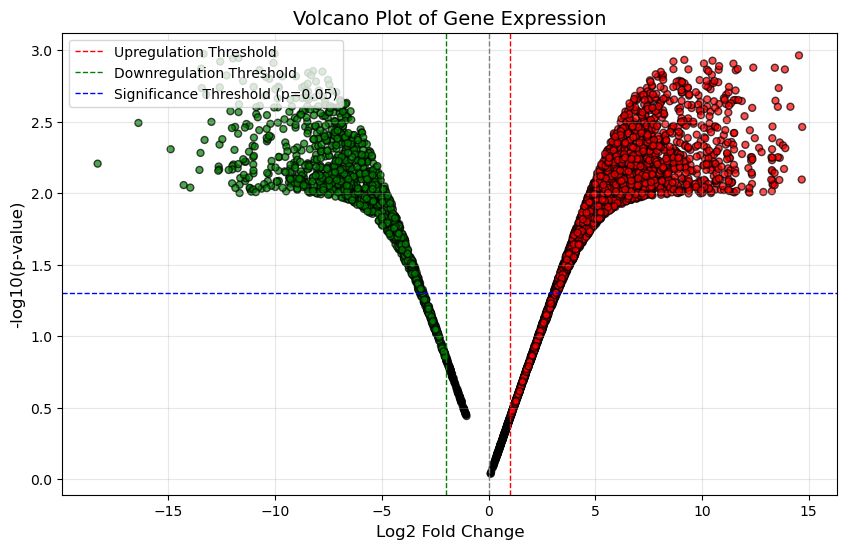

Volcano plot saved as './Liver_cancer/volcano_plot_with_log10pvalue.png'.


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Replace with the path to your actual dataset
file_path = './Liver_cancer/genes_tpm.csv'

# Load the dataset (ensure it's tab-separated or adjust delimiter)
data = pd.read_csv(file_path, sep='\t')

# Check the first few rows of the data
print("Data preview:")
print(data.head())

# Define column names (ensure these match your dataset)
log2fc_column = 'Log2fold change'  # Replace with your column name
gene_id_column = 'Gene_ID'  # Replace with your column name

# Generate synthetic p-values based on log2 fold change
# Add variability for visual effect
np.random.seed(42)  # For reproducibility
data['p_value'] = np.exp(-np.abs(data[log2fc_column])) + np.random.uniform(0.001, 0.01, size=len(data))

# Calculate -log10(p-value) for the y-axis
data['-log10(p-value)'] = -np.log10(data['p_value'] + 1e-10)  # Avoid log(0)

# Define thresholds
threshold_up = 1  # Log2 fold change > 1
threshold_down = -2  # Log2 fold change < -1
significance_level = 0.05  # p-value cutoff

# Assign colors for upregulated, downregulated, and baseline genes
data['color'] = 'black'  # Default color for baseline genes
data.loc[data[log2fc_column] > threshold_up, 'color'] = 'red'  # Upregulated
data.loc[data[log2fc_column] < threshold_down, 'color'] = 'green'  # Downregulated

# Create the volcano plot
plt.figure(figsize=(10, 6))
plt.scatter(data[log2fc_column], data['-log10(p-value)'], c=data['color'], alpha=0.7, edgecolor='k', s=25)

# Add threshold lines
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)
plt.axvline(x=threshold_up, color='red', linestyle='--', linewidth=1, label='Upregulation Threshold')
plt.axvline(x=threshold_down, color='green', linestyle='--', linewidth=1, label='Downregulation Threshold')
plt.axhline(y=-np.log10(significance_level), color='blue', linestyle='--', linewidth=1, label='Significance Threshold (p=0.05)')

# Customize the plot
plt.title('Volcano Plot of Gene Expression', fontsize=14)
plt.xlabel('Log2 Fold Change', fontsize=12)
plt.ylabel('-log10(p-value)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

# Save the plot
output_plot_path = './Liver_cancer/volcano_plot_with_log10pvalue.png'  # Adjust as needed
plt.savefig(output_plot_path, dpi=300)
plt.show()

print(f"Volcano plot saved as '{output_plot_path}'.")

# KEGG AND GO PATHWAY ANALYSIS 

In [57]:
pip install gprofiler-official

Note: you may need to restart the kernel to use updated packages.


In [73]:
import pandas as pd
from gprofiler import GProfiler

# Path to the differentially expressed genes file (tab-separated file)
differentially_expressed_genes_file = './Liver_cancer/differentially_expressed_genes.csv'  # Update the file path

# Load the tab-separated file into a DataFrame
differentially_expressed_genes = pd.read_csv(differentially_expressed_genes_file, sep='\t')

# Extract the list of unique gene IDs from the 'Gene_ID' column
gene_list = differentially_expressed_genes['Gene_ID'].unique().tolist()

# Initialize GProfiler for functional enrichment analysis
gp = GProfiler(return_dataframe=True)

# Perform KEGG enrichment analysis
kegg_results = gp.profile(
    organism='hsapiens',  # Specify the organism (here 'hsapiens' for humans)
    query=gene_list,      # List of differentially expressed genes
    sources=['KEGG'],     # Perform enrichment for KEGG pathways
    all_results=True      # Retrieve all results, including those below significance
)

# Add the list of input gene IDs to the KEGG results for traceability
kegg_results['Input_Genes'] = ', '.join(gene_list)

# Save the KEGG results to a tab-separated file
kegg_output_file = './Liver_cancer/kegg_enrichment_results.tsv'  # Update the output file path
kegg_results.to_csv(kegg_output_file, sep='\t', index=False)

# Perform GO enrichment analysis
go_results = gp.profile(
    organism='hsapiens',  # Specify the organism (here 'hsapiens' for humans)
    query=gene_list,      # List of differentially expressed genes
    sources=['GO'],       # Perform enrichment for Gene Ontology (GO)
    all_results=True      # Retrieve all results, including those below significance
)

# Add the list of input gene IDs to the GO results for traceability
go_results['Input_Genes'] = ', '.join(gene_list)

# Save the GO results to a tab-separated file
go_output_file = './Liver_cancer/go_enrichment_results.tsv'  # Update the output file path
go_results.to_csv(go_output_file, sep='\t', index=False)

print(f"KEGG enrichment results saved to '{kegg_output_file}'.")
print(f"GO enrichment results saved to '{go_output_file}'.")


KEGG enrichment results saved to './Liver_cancer/kegg_enrichment_results.tsv'.
GO enrichment results saved to './Liver_cancer/go_enrichment_results.tsv'.


Initial GO Results:
  source      native                                      name       p_value  \
0  GO:CC  GO:0005737                                 cytoplasm  5.359085e-16   
1  GO:CC  GO:0043227                membrane-bounded organelle  1.906240e-12   
2  GO:CC  GO:0005622        intracellular anatomical structure  8.809595e-12   
3  GO:BP  GO:0044281          small molecule metabolic process  3.145531e-10   
4  GO:CC  GO:0043231  intracellular membrane-bounded organelle  4.931059e-10   

   significant                                        description  term_size  \
0         True  "The contents of a cell excluding the plasma m...      12345   
1         True  "Organized structure of distinctive morphology...      15671   
2         True  "A component of a cell contained within (but n...      17834   
3         True  "The chemical reactions and pathways involving...       1813   
4         True  "Organized structure of distinctive morphology...      14605   

   query_size  int

/tmp/ipykernel_3265/2286051623.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_go_results['p_value'] = top_go_results['p_value'].replace(0, 1e-10)  # Replace 0 with a small value
/tmp/ipykernel_3265/2286051623.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='p_value', y='name', data=top_go_results, palette='magma')


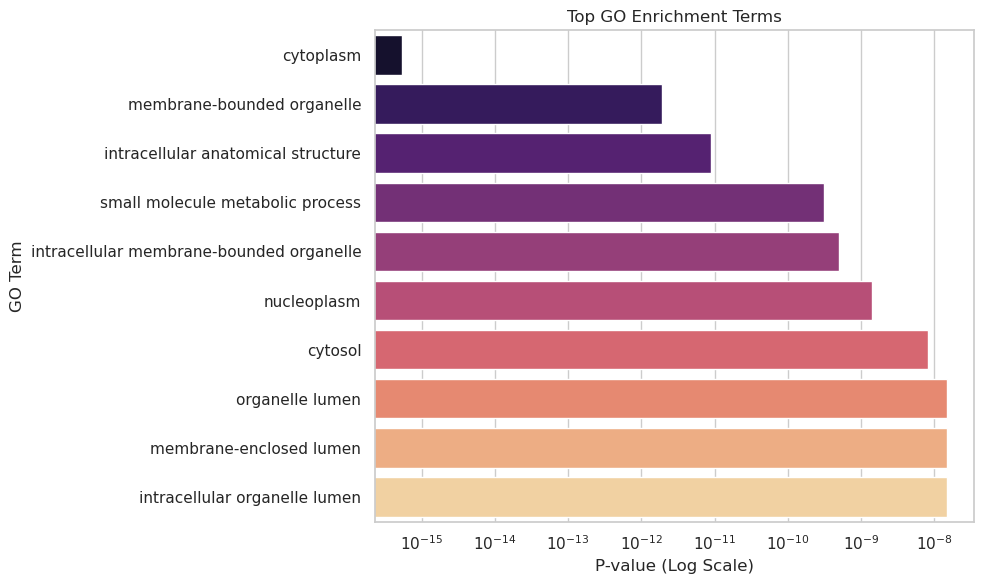

Plot saved at ./Liver_cancer/go_enrichment_terms_plot.png


In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load GO enrichment results from the tab-separated file
go_results_file = './Liver_cancer/go_enrichment_results.tsv'
go_results_df = pd.read_csv(go_results_file, sep='\t')  # Specify tab separator

# Print the first few rows of the dataframe to check the initial data
print("Initial GO Results:")
print(go_results_df.head())

# Filter significant results and sort by p-value
if 'significant' in go_results_df.columns:
    go_results_df = go_results_df[go_results_df['significant']]
    print(f"Number of significant results: {len(go_results_df)}")  # Check number of significant results
else:
    print("Column 'significant' not found in the input file. Please ensure the file format is correct.")
    exit()

# Convert p_value to numeric
if 'p_value' in go_results_df.columns:
    go_results_df['p_value'] = pd.to_numeric(go_results_df['p_value'], errors='coerce')

    # Check for any NaN values after conversion
    print("Checking for NaN values in p_value after conversion:")
    print(go_results_df['p_value'].isna().sum())
else:
    print("Column 'p_value' not found in the input file. Please ensure the file format is correct.")
    exit()

# Sort values and select top 10 results
go_results_df = go_results_df.sort_values(by='p_value')

# Select top 10 results (or all if less than 10)
top_go_results = go_results_df.head(10)

# Print the top GO results to check if it's empty or contains valid data
print("Top GO Results:")
print(top_go_results)

# Check if top_go_results is empty
if top_go_results.empty:
    print("No results available for plotting.")
else:
    # Add a small constant to p-values for log scale
    top_go_results['p_value'] = top_go_results['p_value'].replace(0, 1e-10)  # Replace 0 with a small value

    # Set up the visualization style
    sns.set(style="whitegrid")

    # Create a horizontal bar plot for GO enrichment results
    plt.figure(figsize=(10, 6))
    sns.barplot(x='p_value', y='name', data=top_go_results, palette='magma')
    plt.title('Top GO Enrichment Terms')
    plt.xlabel('P-value (Log Scale)')
    plt.ylabel('GO Term')

    # Set the x-axis to log scale
    plt.xscale('log')  # Log scale for better visualization of p-values

    plt.tight_layout()

    # Save the plot
    plot_save_path = './Liver_cancer/go_enrichment_terms_plot.png'
    plt.savefig(plot_save_path)

    # Display the plot
    plt.show()

    print(f"Plot saved at {plot_save_path}")


Initial KEGG Results:
  source      native                                          name  \
0   KEGG  KEGG:00980  Metabolism of xenobiotics by cytochrome P450   
1   KEGG  KEGG:00982             Drug metabolism - cytochrome P450   
2   KEGG  KEGG:00053             Ascorbate and aldarate metabolism   
3   KEGG  KEGG:01100                            Metabolic pathways   
4   KEGG  KEGG:05204         Chemical carcinogenesis - DNA adducts   

        p_value  significant                                   description  \
0  1.007225e-07         True  Metabolism of xenobiotics by cytochrome P450   
1  1.226331e-06         True             Drug metabolism - cytochrome P450   
2  7.561819e-05         True             Ascorbate and aldarate metabolism   
3  3.740364e-04         True                            Metabolic pathways   
4  1.418416e-03         True         Chemical carcinogenesis - DNA adducts   

   term_size  query_size  intersection_size  effective_domain_size  precision  \
0      

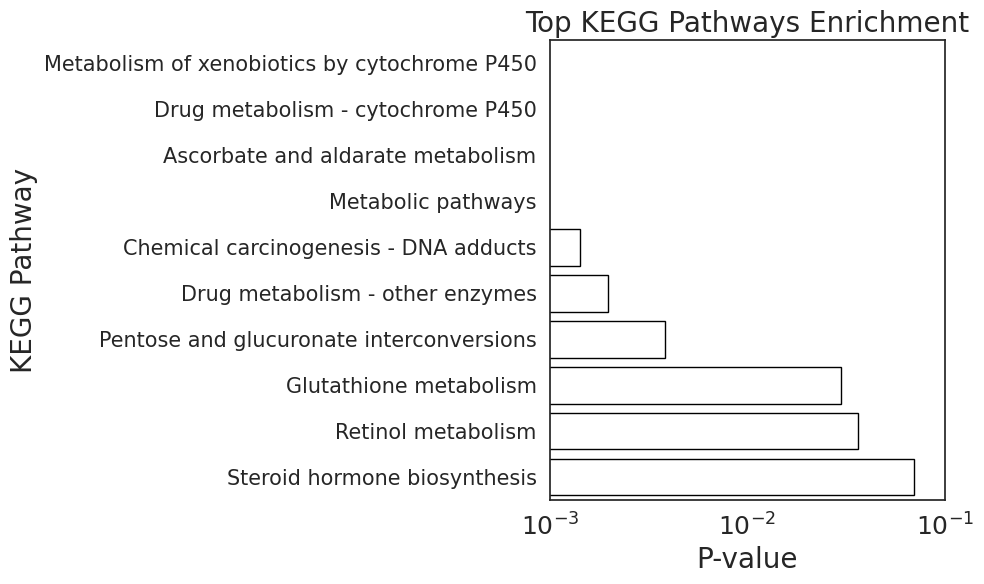

Plot saved at ./Liver_cancer/top_kegg_enrichment_plot.png


In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load KEGG results
kegg_results_file = "./Liver_cancer/kegg_enrichment_results.tsv"  # Ensure file path is correct
kegg_results = pd.read_csv(kegg_results_file, sep='\t')  # Specify tab separator

# Print the first few rows of the dataframe to check the initial data
print("Initial KEGG Results:")
print(kegg_results.head())

# Set up the visualization style to remove grid lines
sns.set(style="white")

# Function to plot KEGG results
def plot_kegg_results(kegg_df, top_n=10):
    # Ensure p_value column is numeric
    kegg_df['p_value'] = pd.to_numeric(kegg_df['p_value'], errors='coerce')

    # Check for NaN values and filter them out
    kegg_df = kegg_df.dropna(subset=['p_value'])

    # Select top N results based on p-value
    top_kegg = kegg_df.nsmallest(top_n, 'p_value')

    # Plot the top KEGG results
    plt.figure(figsize=(10, 6))
    # Set color to white for the bars and add edge color for visibility
    sns.barplot(x='p_value', y='name', data=top_kegg, color='white', edgecolor='black')  # Edgecolor for visibility

    # Set title and labels with increased font size
    plt.title('Top KEGG Pathways Enrichment', fontsize=20)
    plt.xlabel('P-value', fontsize=20)
    plt.ylabel('KEGG Pathway', fontsize=20)

    # Customize ticks and scale
    plt.xticks(fontsize=18)  # Increase x-tick font size
    plt.yticks(fontsize=15)  # Increase y-tick font size
    plt.xscale('log')  # Log scale for better visualization of p-values
    plt.xlim(0.001, 0.1)  # Set x-axis limits to 10^-3 to 10^-1
    plt.tight_layout()

    # Save the plot
    plot_save_path = "./Liver_cancer/top_kegg_enrichment_plot.png"
    plt.savefig(plot_save_path)

    # Show the plot
    plt.show()

    print(f"Plot saved at {plot_save_path}")

# Plotting the results
plot_kegg_results(kegg_results)
